In [8]:
from scipy.stats import nbinom, binom, poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import os
from scipy.optimize import minimize, Bounds
import inspect
from scipy.stats import poisson
from scipy.stats import chisquare

In [3]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Thalia, Mai/verarbeitete_daten'
filename = 'Pivot_Trans_Privat_ohneApple_Langzeitkunde.csv'

df_trans_werte = pd.read_csv(os.path.join(path, filename))

In [4]:
df_trans_werte.head()

,iid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,100056041,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100057957,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,100059553,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100062565,4.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,3.0,0.0
4,100062713,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


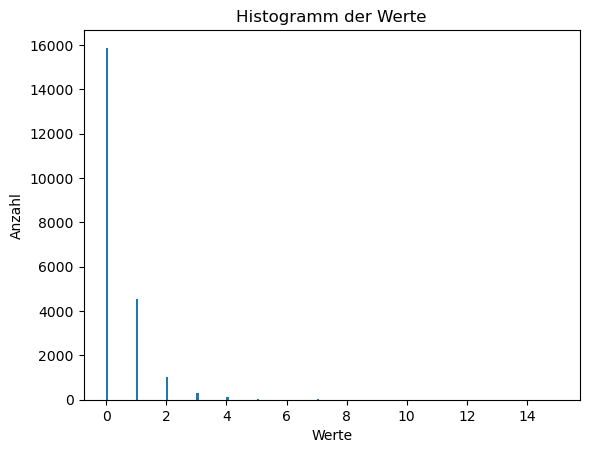

In [6]:
# Alle Spalten auswählen außer 'iid'
columns_to_plot = df_trans_werte.columns[df_trans_werte.columns != 'iid']

# Histogramm erstellen
plt.hist(df_trans_werte[columns_to_plot].values.flatten(), bins="auto")
plt.xlabel('Werte')
plt.ylabel('Anzahl')
plt.title('Histogramm der Werte')
plt.show()

In [89]:
data = df_trans_werte[columns_to_plot].values.flatten()
data

array([1., 0., 0., ..., 0., 0., 0.])

In [91]:
X = np.ones_like(data)
res= sm.NegativeBinomial(data,X).fit(start_params = [1,1])
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.814262
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                21930
Model:               NegativeBinomial   Df Residuals:                    21929
Method:                           MLE   Df Model:                            0
Date:                Thu, 22 Jun 2023   Pseudo R-squ.:              -3.534e-10
Time:                        12:56:45   Log-Likelihood:                -17857.
converged:                       True   LL-Null:                       -17857.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9629      0.013    -7

In [92]:
mu = np.exp(res.params[0])
p = 1/(1+np.exp(res.params[0])*res.params[1])
n = np.exp(res.params[0])*p/(1-p)
mu,p,n

(0.38176959574353525, 0.7004265019423394, 0.892607471049115)

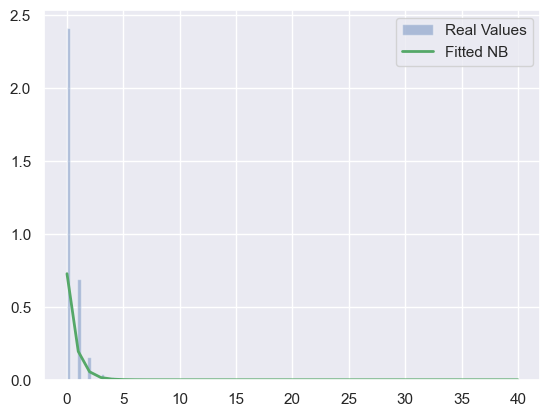

In [93]:
x_plot = np.linspace(0,40,41)
sns.set_theme()
ax = sns.distplot(data, kde = False, norm_hist = True, label = "Real Values")
ax.plot(x_plot, nbinom.pmf(x_plot, n, p), "g-", lw=2, label = "Fitted NB")
leg = ax.legend()

from scipy.stats import kstest


# Annahme: Verteilungsfunktion definiert als CDF (Cumulative Distribution Function)
def my_distribution(x):
    # Hier kannst du deine Verteilungsfunktion implementieren
    # Gib den kumulativen Wahrscheinlichkeitswert für x zurück
    # Beispiel: Gleichverteilung auf dem Intervall [1, 10]
    return (x - 1) / 10

# Kolmogorov-Smirnov-Test
D, p_value = kstest(data, my_distribution)

# Ergebnis ausgeben
print("Kolmogorov-Smirnov-Teststatistik:", D)
print("P-Wert:", p_value)

In [94]:
from scipy.optimize import minimize

int_data = data.astype(int)
ecdf = sm.distributions.ECDF(int_data)

def my_distribution(y, phi, lambdaY, r):
    cdf = np.zeros_like(y, dtype=float)
    if r > 0:
        for i in range(len(y)):
            for j in range(y[i] + 1):
                if j == 0:
                    pmf = phi + (1 - phi) * (1 + lambdaY / r)**(-r)
                elif j > 0:
                    numerator = math.gamma(j + r)
                    denominator = math.factorial(j) * math.gamma(r)
                    gamma_term = numerator / denominator
                    pmf= (1 - phi) * gamma_term * (1 + lambdaY / r)**(-r) * (1 + r / lambdaY)**(-j)
                cdf[i] += pmf
    return cdf

# Funktion zur Berechnung der Summe der quadratischen Abweichungen
def squared_error(params):
    phi, lambdaY = params
    predicted_values = my_distribution(int_data, phi, lambdaY, 2)
    error = ecdf(int_data) - predicted_values
    squared_error = np.sum(error**2)
    return squared_error

# Anfangsschätzwerte für die Parameter
initial_guess = [1, 1]
# Grenzen (Bounds)
bounds = [(0, 1), (0, 9999)]


# Parameter schätzen
result = minimize(squared_error, initial_guess, bounds=bounds)

# Geschätzte Parameter auslesen
estimated_params = result.x

# Ergebnis ausgeben
print("Geschätzte Parameter:", estimated_params)

Geschätzte Parameter: [0.12249943 0.4153646 ]


In [42]:
ecdf = sm.distributions.ECDF(int_data)

In [47]:
ecdf(int_data)

array([0.93173735, 0.72412221, 0.72412221, ..., 0.72412221, 0.72412221,
       0.72412221])

In [ ]:
x_plot = np.linspace(0,40,41)
sns.set_theme()
ax = sns.distplot(data, kde = False, norm_hist = True, label = "Real Values")
ax.plot(x_plot, nbinom.pmf(x_plot, n, p), "g-", lw=2, label = "Fitted NB")
leg = ax.legend()

(array([1.588e+04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.553e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.025e+03, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.840e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.170e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.500e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

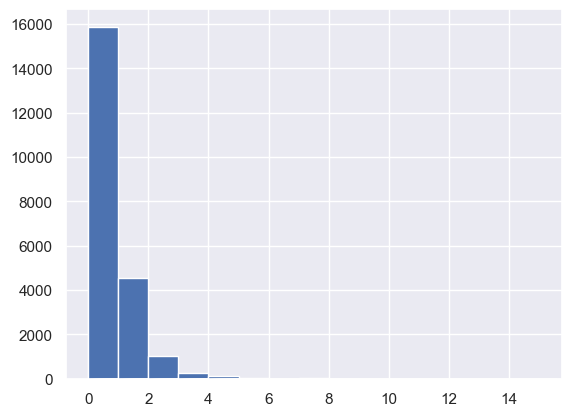

In [105]:
plt.hist(int_data,bins = "auto",width = 1)

In [117]:
from scipy.stats import ks_2samp

# Anfangsschätzwerte für die Parameter
initial_guess = [1, 1]
# Grenzen (Bounds)
bounds = [(0, 1), (0, 9999)]

# Annahme: cdf1 und cdf2 sind die beiden zu vergleichenden CDFs

for k in [ 9, 10, 11]:

    # Parameter schätzen
    result = minimize(squared_error, initial_guess, bounds=bounds)

    # Geschätzte Parameter auslesen
    estimated_params = result.x
    dist = my_distribution(int_data, estimated_params[0], estimated_params[1], 2)
    # Führe den KS-Test durch
    statistic, p_value = ks_2samp(my_distribution(int_data, estimated_params[0], estimated_params[1], 2), ecdf(int_data))
    print("r=" + str(k))
    print(statistic)
    print(p_value)

r=9
0.7241222070223439
0.0
r=10
0.7241222070223439
0.0
r=11
0.7241222070223439
0.0


(array([15880.,     0.,     0.,     0.,     0.,     0.,     0.,  4553.,
            0.,  1497.]),
 array([0.72414678, 0.7517321 , 0.77931742, 0.80690274, 0.83448807,
        0.86207339, 0.88965871, 0.91724403, 0.94482936, 0.97241468,
        1.        ]),
 <BarContainer object of 10 artists>)

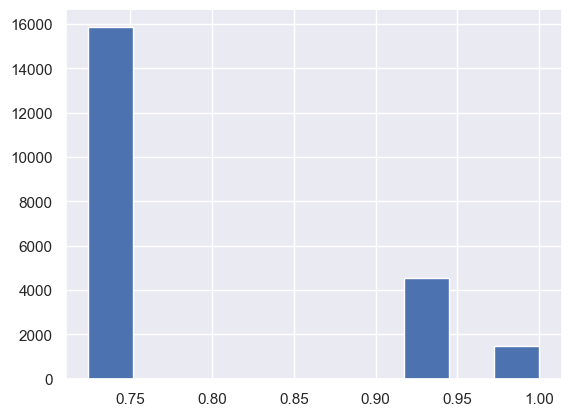

In [118]:
plt.hist(my_distribution(int_data, estimated_params[0], estimated_params[1], 2))

(array([15880.,     0.,     0.,     0.,     0.,     0.,     0.,  4553.,
            0.,  1497.]),
 array([0.72412221, 0.75170999, 0.77929777, 0.80688554, 0.83447332,
        0.8620611 , 0.88964888, 0.91723666, 0.94482444, 0.97241222,
        1.        ]),
 <BarContainer object of 10 artists>)

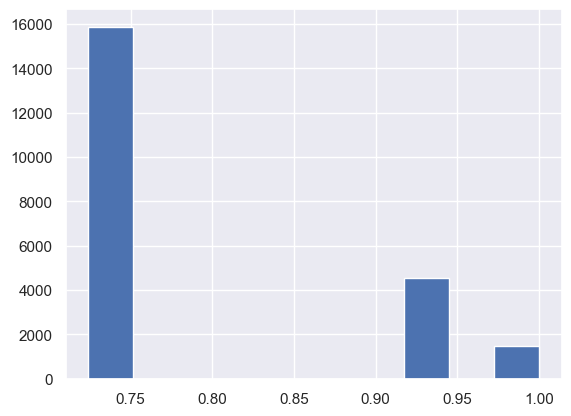

In [119]:
plt.hist(ecdf(int_data))

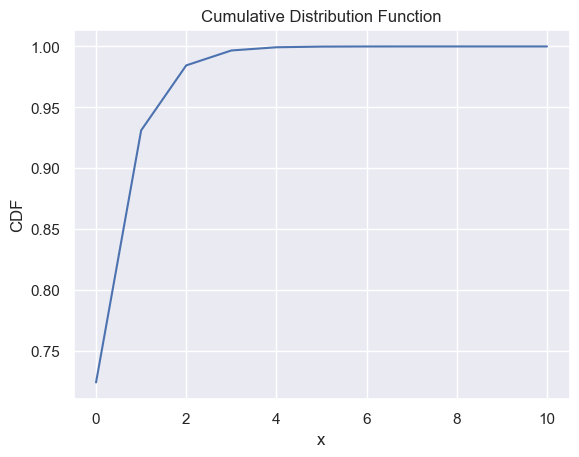

In [126]:
import numpy as np
import matplotlib.pyplot as plt

phi = 0.12249943
lambdaY = 0.4153646
r = 2

def cdf(y, phi, lambdaY, r):
    cdf = np.zeros_like(y, dtype=float)
    if r > 0:
        for i in range(len(y)):
            for j in range(y[i] + 1):
                if j == 0:
                    pmf = phi + (1 - phi) * (1 + lambdaY / r)**(-r)
                elif j > 0:
                    numerator = math.gamma(j + r)
                    denominator = math.factorial(j) * math.gamma(r)
                    gamma_term = numerator / denominator
                    pmf= (1 - phi) * gamma_term * (1 + lambdaY / r)**(-r) * (1 + r / lambdaY)**(-j)
                cdf[i] += pmf
    return cdf

# Definitionsbereich der CDF
x_values = np.linspace(0, 10, 10).astype(int)

# Berechnung der CDF-Werte
#cdf_values = np.vectorize(cdf(x_values, phi, lambdaY, r))

# Plot der CDF
plt.plot(x_values, cdf(x_values, phi, lambdaY, r))
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.show()


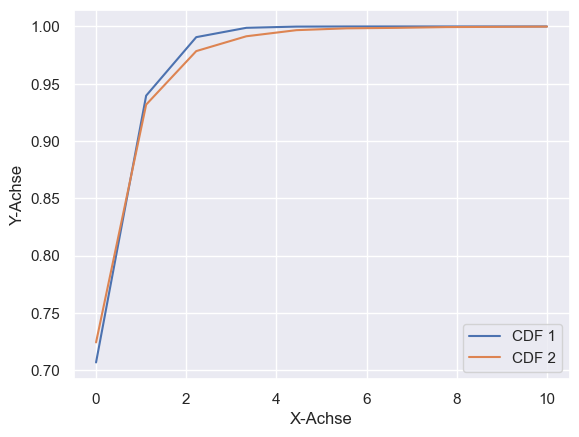

In [134]:
import numpy as np
import matplotlib.pyplot as plt

phi = 0.12249943
lambdaY = 0.4153646
r = 10

# Daten für die erste CDF
x1 = np.linspace(0, 10, 10)
y1 = cdf(x_values, phi, lambdaY, r)

# Daten für die zweite CDF
x2 = np.linspace(0, 10, 10)
y2 = ecdf(x2)

# Plot der ersten CDF
plt.plot(x1, y1, label='CDF 1')

# Plot der zweiten CDF
plt.plot(x2, y2, label='CDF 2')

# Achsentitel und Legende hinzufügen
plt.xlabel('X-Achse')
plt.ylabel('Y-Achse')
plt.legend()

# Plot anzeigen
plt.show()


In [72]:
data = np.array([0,0,1])
# ZINB-Modell anpassen
def zinb_model(params):
    mu, alpha, pi = params
    model = sm.ZeroInflatedNegativeBinomialP(data, exog=None, exog_infl =data)
    result = model.fit(start_params=[mu, alpha, pi], maxiter=100)
    return result

In [70]:
print("Model: Zero Inflated Neg. Binomial")
zinb_mod = sm.ZeroInflatedNegativeBinomialP(ytrain, xtrain).fit(method="nm", maxiter=50)
zinb_pred = zinb_mod.predict(xtest, exog_infl=np.ones((len(xtest), 1)))
zinb_rmse = np.sqrt(mean_squared_error(ytest, zinb_pred))

Model: Zero Inflated Neg. Binomial


NameError: name 'ytrain' is not defined

In [77]:
zinb_model([0.5, 0.5, 2])

ValueError: array must not contain infs or NaNs

In [ ]:
from scipy.optimize import minimize

int_data = data.astype(int)
ecdf = sm.distributions.ECDF(int_data)

def my_distribution(y, phi, lambdaY, r):
    cdf = np.zeros_like(y, dtype=float)
    if r > 0:
        for i in range(len(y)):
            for j in range(y[i] + 1):
                if j == 0:
                    pmf = phi + (1 - phi) * (1 + lambdaY / r)**(-r)
                elif j > 0:
                    numerator = math.gamma(j + r)
                    denominator = math.factorial(j) * math.gamma(r)
                    gamma_term = numerator / denominator
                    pmf= (1 - phi) * gamma_term * (1 + lambdaY / r)**(-r) * (1 + r / lambdaY)**(-j)
                cdf[i] += pmf
    return cdf

# Funktion zur Berechnung der Summe der quadratischen Abweichungen
def squared_error(params):
    phi, lambdaY, r = params
    predicted_values = my_distribution(int_data, phi, lambdaY, r)
    error = ecdf(int_data) - predicted_values
    squared_error = np.sum(error**2)
    return squared_error

# Anfangsschätzwerte für die Parameter
initial_guess = [1, 1, 1]
# Grenzen (Bounds)
bounds = [(0, 1), (0, 9999), (0, 7)]


# Parameter schätzen
result = minimize(squared_error, initial_guess, bounds=bounds)

# Geschätzte Parameter auslesen
estimated_params = result.x

# Ergebnis ausgeben
print("Geschätzte Parameter:", estimated_params)

In [78]:
zip_training_results = sm.ZeroInflatedPoisson(endog=data, exog=None, exog_infl=data, inflation='logit').fit()

ValueError: array must not contain infs or NaNs

In [ ]:
statsmodels.discrete.count_model.ZeroInflatedNegativeBinomialP

In [85]:
model = sm.ZeroInflatedNegativeBinomialP.cdf(data)

TypeError: cdf() missing 1 required positional argument: 'X'

In [ ]:
gestern:
    Iterpretation der Ergebnisse
    Datenauswahl formuliert
    Roustheitstest durchgeführt
    
huete:
    weitere robustheitstests
    ergeisse der valdierung in die arbeit aufehmen
    